In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from sklearn.model_selection import KFold
from matplotlib.lines import Line2D

from sklearn.neighbors import KernelDensity
import math

from scipy.optimize import minimize
from scipy.linalg import cholesky

# If running on separate laptop/computer, this will need commenting out 
plt.style.use('pythonStyle')
import pythonStyle as ed

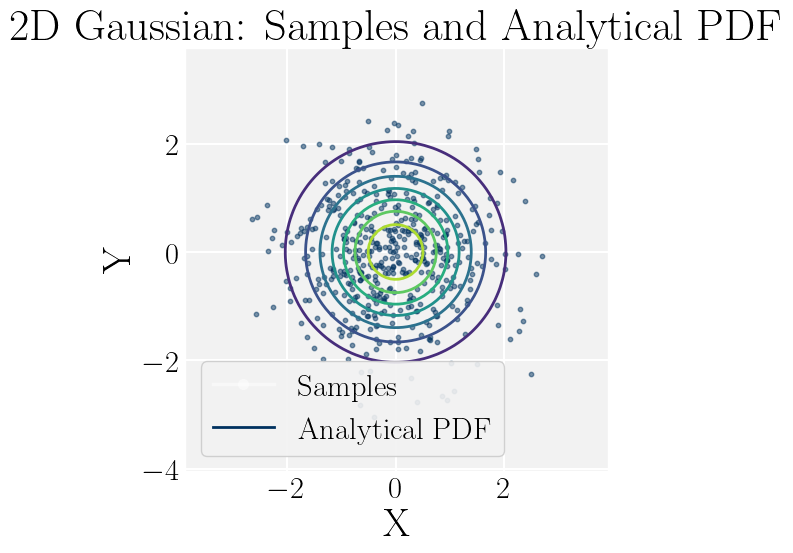

In [3]:
# Parameters for the 2D Gaussian
mu1 = [0, 0]                      # Mean
cov1 = [[1, 0], [0, 1]]           # Covariance matrix

# Generate samples
n_samples = 500
np.random.seed(0)
samples = np.random.multivariate_normal(mu1, cov1, n_samples)

# Define axis limits for square grid
x_min, x_max = np.min(samples[:,0]) - 1, np.max(samples[:,0]) + 1
y_min, y_max = np.min(samples[:,1]) - 1, np.max(samples[:,1]) + 1

# Make ranges equal length for square grid
range_x = x_max - x_min
range_y = y_max - y_min
max_range = max(range_x, range_y)

# Center the ranges to have equal span
x_mid = (x_max + x_min) / 2
y_mid = (y_max + y_min) / 2

x = np.linspace(x_mid - max_range/2, x_mid + max_range/2, 100)
y = np.linspace(y_mid - max_range/2, y_mid + max_range/2, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Compute the analytical PDF on the grid
rv = multivariate_normal(mu1, cov1)
Z = rv.pdf(pos)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(samples[:,0], samples[:,1], s=10, alpha=0.5, label='Samples')
contour = plt.contour(X, Y, Z, linewidths=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian: Samples and Analytical PDF')

# Set aspect ratio to equal to ensure square axes
plt.axis('square')

# Custom legend
plt.legend(handles=[
    Line2D([0], [0], marker='o', color='w', markersize=8, label='Samples', alpha=0.5),
    Line2D([0], [0], lw=2, label='Analytical PDF')
])

plt.grid(True)
plt.show()


In [4]:
## Calculating with a diagonal bandwidth matrix -> no covariance assumed

# --- Generate 2D Gaussian samples
def generate_2d_gaussian_samples(n, mu, cov, seed=0):
    np.random.seed(seed)
    data = np.random.multivariate_normal(mu, cov, size=n).astype(np.float32)
    return data 

########################################################################
########################################################################

# --- calculate the bandwidth matrix
def calc_bandwidthMatrix(data, n=100000):
    
    # Calculate Silverman bandwidth vector
    n, d = data.shape
    sigma = np.std(data, axis=0, ddof=1)
    h_p = (4 / (d + 2)) ** (1 / (d + 4)) * n ** (-1 / (d + 4)) * sigma
    print(f'Initial h_p: {h_p}')

    # Create candidate bandwidth matrices
    scaling_factors = np.linspace(0.5, 2.0, 10)

    H_Matrix_candidateLst = []
    hLst = []
    for s in scaling_factors:
        H_diag = (s * h_p) ** 2 
        H_matrix = np.diag(H_diag)
        H_Matrix_candidateLst.append(H_matrix)
        hLst.append(H_diag)
    
    # Cross-validation
    bandwidthMatrix, mean_logLikelihoodLst = calc_kdeCrossValidation_nD(data, H_Matrix_candidateLst, k=5, subsample_size=10000)
    print(bandwidthMatrix)

    return bandwidthMatrix, mean_logLikelihoodLst, hLst

# --- Cross-validation of KDE bandwidth matrix- using subsampling for speed
def calc_kdeCrossValidation_nD(data, H_Matrix_candidateLst, k=5, subsample_size=10000):
    n, d = data.shape
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # shuffle the data before splitting into k groups
    mean_logLikelihoodLst = []

    # Use subsampling to reduce computation
    if n > subsample_size:
        indices = np.random.choice(n, subsample_size, replace=False)
        data_sub = data[indices]
    else:
        data_sub = data

    for H in H_Matrix_candidateLst:
        H = np.array(H)
        H_inv = np.linalg.inv(H)
        det_H = np.linalg.det(H)

        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_H))

        fold_log_likelihoods = []

        for train_idx, val_idx in kf.split(data_sub):
            X_train = data_sub[train_idx]
            X_val = data_sub[val_idx]

            diffs = X_val[:, np.newaxis, :] - X_train[np.newaxis, :, :]
            dists = np.einsum('mnd,dd,mnd->mn', diffs, H_inv, diffs)
            K = norm_const * np.exp(-0.5 * dists)

            f_vals = np.mean(K, axis=1)
            f_vals = np.clip(f_vals, 1e-300, None)
            fold_log_likelihoods.append(np.mean(np.log(f_vals)))

        mean_logLikelihoodLst.append(np.mean(fold_log_likelihoods))

    mean_logLikelihoodLst = np.array(mean_logLikelihoodLst)
    optimal_idx = np.argmax(mean_logLikelihoodLst)
    optimalBandwidthMatrix = H_Matrix_candidateLst[optimal_idx]

    return optimalBandwidthMatrix, mean_logLikelihoodLst

# --- calcualte the PDF estimate and KDE estimate
def calc_pdf_and_kde_values(data, bandwidthMatrix, dim):

    # Get scalar bandwidth h = sqrt of diagonal element from bandwidthMatrix
    data_1d = data[:, dim]
    h = np.sqrt(bandwidthMatrix[dim, dim])

    # Compute mean and std for that dimension
    mean_x = np.mean(data_1d)
    std_x = np.std(data_1d, ddof=0)

    print(f"Using bandwidth h extracted from bandwidthMatrix diagonal: h = {h:.5f}")
    print(f"Mean = {round(mean_x, 5)}, Std = {round(std_x, 5)}")

    # Generate x values for plotting KDE and PDF
    x_vals = np.linspace(np.min(data_1d), np.max(data_1d), 500)

    # Empirical PDF assuming Gaussian distribution
    pdf_vals = norm.pdf(x_vals, loc=mean_x, scale=std_x)

    # calculate KDE values
    kde_vals = np.zeros_like(x_vals)
    for i, x in enumerate(x_vals):
        diff = (x - data_1d) / h
        kde_vals[i] = np.mean(np.exp(-0.5 * diff**2)) / (np.sqrt(2 * np.pi) * h)

    return x_vals, pdf_vals, kde_vals

# --- Calculate KL divergence in 1D - between two choosen flavours
def calc_KLDivergence(data, kde_vals_x, kde_vals_y, pdf_x, pdf_y):

    # Assume uniform spacing
    x_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), len(kde_vals_x))
    y_vals = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), len(kde_vals_y))
    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]

    # KL divergence: KDE vs True
    kl_x = np.sum(kde_vals_x * np.log(kde_vals_x / pdf_x)) * dx
    kl_y = np.sum(kde_vals_y * np.log(kde_vals_y / pdf_y)) * dy

    # print stuff
    print(f"\nKL divergence (X marginal): {kl_x:.6f}")
    print(f"KL divergence (Y marginal): {kl_y:.6f}\n")


def calc_KLDivergence_2D(grid_points, kde_vals_2d, pdf_vals_2d):
    """
    Compute KL divergence D_KL(P || Q) over a 2D grid, where
    P = KDE estimate
    Q = reference PDF (true Gaussian)
    
    Both inputs must be defined on the same grid.
    """

    # Flatten both input 2D arrays to 1D for element-wise operations
    p = kde_vals_2d.flatten()
    q = pdf_vals_2d.flatten()

    # Prevent log(0) and divide-by-zero
    p = np.clip(p, 1e-300, None)
    q = np.clip(q, 1e-300, None)

    # Get grid spacing (assumes uniform)
    x_unique = np.unique(grid_points[:, 0])
    y_unique = np.unique(grid_points[:, 1])
    dx = x_unique[1] - x_unique[0]
    dy = y_unique[1] - y_unique[0]
    dA = dx * dy

    # KL divergence D_KL(P || Q)
    kl_2d = np.sum(p * np.log(p / q)) * dA

    print(f"\nKL divergence (2D): {kl_2d:.6f}\n")
    return kl_2d



# --- Estimate KDE at given points using batching 
def calc_kdeGaussianEstimate_nD(points, data, bandwidth, batch_size=50):
    n, d = data.shape
    m = points.shape[0]

    bandwidth_inv = np.linalg.inv(bandwidth)
    det_bandwidth = np.linalg.det(bandwidth)
    norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_bandwidth))

    densities = np.empty(m, dtype=np.float32)

    for start in range(0, m, batch_size): # calculate in batches to reduce computational load
        end = min(start + batch_size, m)
        batch = points[start:end].astype(np.float32) # slices to get a subset of points (exclusive slicing)
        diffs = batch[:, np.newaxis, :] - data  # (b, n, d)
        D2 = np.einsum('bnd,dd,bnd->bn', diffs, bandwidth_inv, diffs) # einsum - sinstein summation, general syntax is np.einsum(subscripts, *operands), these are the input subscripts bnd,dd,bnd and the output subscript is bn and summuation is over d because it doesnt appear in the outputs
        kernel_vals = norm_const * np.exp(-0.5 * D2)
        densities[start:end] = np.mean(kernel_vals, axis=1)

    return densities

########################################################################
########################################################################

# --- Plot histogram
def plot_1D_histogram(data, x_vals, pdf_vals, kde_vals, dim, bins=50):

    data_1d = data[:, dim]

    # Plot histogram, empirical PDF, and KDE estimate
    plt.figure(figsize=(8, 5))
    plt.hist(data_1d, bins=bins, density=True, color='#68A5A1', edgecolor='black', alpha=0.6)
    plt.plot(x_vals, pdf_vals, lw=2, label="Empirical PDF")
    plt.plot(x_vals, kde_vals, '--', lw=2, label="KDE Estimate PDF")
    plt.xlabel(f"Dimension {dim}", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.title("1D Histogram with Empirical PDF and KDE Estimate", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# --- Plot histogram with scatter graph as well
def plot_1D_histogram_withScatter(data, x_vals, pdf_vals, kde_vals, dim, bins=50):
    data_1d = data[:, dim]

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=(4, 2), wspace=0.05)

    print(data_1d)

    # Left: Scatter plot
    ax_main = fig.add_subplot(gs[0])
    ax_main.scatter(np.arange(len(data_1d)), data_1d, color='#68A5A1', s=3)
    ax_main.set_ylabel(f"Dimension {dim}", fontsize=20)
    ax_main.set_xlabel(f"Replica Index", fontsize=20)
    ax_main.set_title("1D Histogram with Empirical PDF and KDE Estimate", fontsize=14)
    ax_main.set_title("1D Scatter Plot and Histogram with Empirical PDF and KDE Estimate", fontsize=16)
    ax_main.tick_params(axis='both', labelsize=12)
    ax_main.grid(True)

    # Right: Rotated histogram (density on x, value on y)
    ax_hist = fig.add_subplot(gs[1], sharey=ax_main)
    hist, bin_edges = np.histogram(data_1d, bins=bins, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bar_width = bin_edges[1] - bin_edges[0]
    ax_hist.barh(
        bin_centers,
        hist,
        height=bar_width,
        color="#68A5A1",
        edgecolor='black',
    )

    # Overlay: empirical PDF (solid line) and KDE estimate (dashed line)
    ax_hist.plot(pdf_vals, x_vals, lw=2, label='Empirical PDF')
    ax_hist.plot(kde_vals, x_vals, lw=2, linestyle='--', label='KDE Estimate')

    ax_hist.set_xlabel('Probability Density', fontsize=12, labelpad=12)
    ax_hist.tick_params(axis='x', labelsize=12)
    ax_hist.tick_params(axis='y', left=False, labelleft=False)
    ax_hist.set_xlim(left=0)
    ax_hist.legend(fontsize=10, loc='lower right')

    plt.tight_layout()
    plt.show()

########################################################################
########################################################################

# --- Plot KDE estimate and PDF estimate in 2D
def plot_kde_vs_pdf_2d(data, kde_vals, pdf_vals, grid_points):
    x_unique = np.unique(grid_points[:, 0])
    y_unique = np.unique(grid_points[:, 1])
    X, Y = np.meshgrid(x_unique, y_unique)

    # Downsample data for plotting if really large
    plot_data = data if data.shape[0] <= 10000 else data[::10]

    plt.scatter(plot_data[:, 0], plot_data[:, 1], c='dimgrey', s=10, alpha=0.3, label='Samples')
    plt.contour(X, Y, kde_vals, colors='navy', linewidths=1.5)
    plt.contour(X, Y, pdf_vals, colors='firebrick', linestyles='dashed', linewidths=1.5)

    legend_elements = [
        Line2D([0], [0], color='navy', lw=1.5, label='KDE Estimate pdf'),
        Line2D([0], [0], color='firebrick', lw=1.5, linestyle='dashed', label='Empirical pdf'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Samples', alpha=0.5)
    ]

    plt.legend(handles=legend_elements, fontsize=12)
    plt.title(f'KDE vs Sample PDF', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cvScores(mean_logLikelihoodLst, hLst):

    plt.figure(figsize=(10, 6))
    plt.plot(hLst, mean_logLikelihoodLst, '-o')
    plt.xlabel('Bandwidth scaling factor (h_p multiplier)', fontsize=14)
    plt.ylabel('Mean Log Likelihood (CV score)', fontsize=14)
    plt.title('Cross-Validation Score', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

########################################################################
########################################################################

# --- Define Distributions and run everything
def main(plotting1D=True, plotting2D=True, kdeGridRes=150):

    cov = [
        [1,0],
        [0,1]
    ]

    mu = [0, 0]
    data = generate_2d_gaussian_samples(n=100000, mu=mu, cov=cov)
    bandwidthMatrix, mean_logLikelihoodLst, hLst= calc_bandwidthMatrix(data)
    plot_cvScores(mean_logLikelihoodLst, hLst)

    d = data.shape[1]
    if plotting1D == True:
        for dim in range(0, d):
            x_vals, pdf_vals, kde_vals = calc_pdf_and_kde_values(data, bandwidthMatrix, dim)
            plot_1D_histogram(data, x_vals, pdf_vals, kde_vals, dim)
            # plot_1D_histogram_withScatter(data, x_vals, pdf_vals, kde_vals, dim)

    if plotting2D == True:
        # Create 2D grid only for selected dims
        grid_axes_2d = [np.linspace(np.min(data[:, dim]) - 1, np.max(data[:, dim]) + 1, kdeGridRes) for dim in range(2)]

        # Create 2D meshgrid and flatten
        X, Y = np.meshgrid(grid_axes_2d[0], grid_axes_2d[1], indexing='xy')
        grid_points_2d = np.vstack([X.ravel(), Y.ravel()]).T.astype(np.float32)  # shape (num_points, 2)
                
        # Compute KDE only on selected dims
        kde_vals_2d = calc_kdeGaussianEstimate_nD(grid_points_2d, data, bandwidthMatrix).reshape(kdeGridRes, kdeGridRes)

        # Calculate sample PDF for selected dims
        sampleMean_2d = np.mean(data, axis=0)
        sampleCovariance_2d = np.cov(data, rowvar=False)
        sampleGaussian_2d = multivariate_normal(mean=sampleMean_2d, cov=sampleCovariance_2d)
        pdf_vals_2d = sampleGaussian_2d.pdf(grid_points_2d).reshape(kdeGridRes, kdeGridRes)

        # Plot with the 2D inputs    
        plot_kde_vs_pdf_2d(data, kde_vals_2d, pdf_vals_2d, grid_points_2d)
        calc_KLDivergence_2D(grid_points_2d, kde_vals_2d, pdf_vals_2d)


# if __name__ == "__main__":
#     main()

/var/folders/y5/q6z5mfgj6_g9z2bwg0jy91km0000gp/T/ipykernel_84971/680677185.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mu, cov, size=n).astype(np.float32)


Estimated bandwidth matrix H: [[0.66933308 0.32946733]
 [0.32946733 0.16723548]]



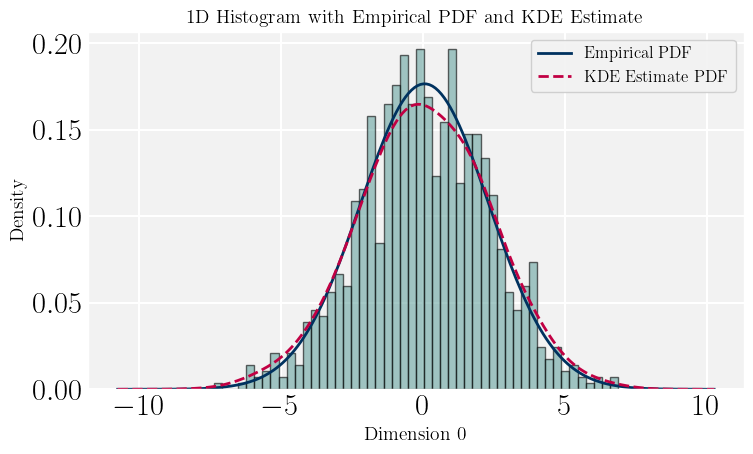

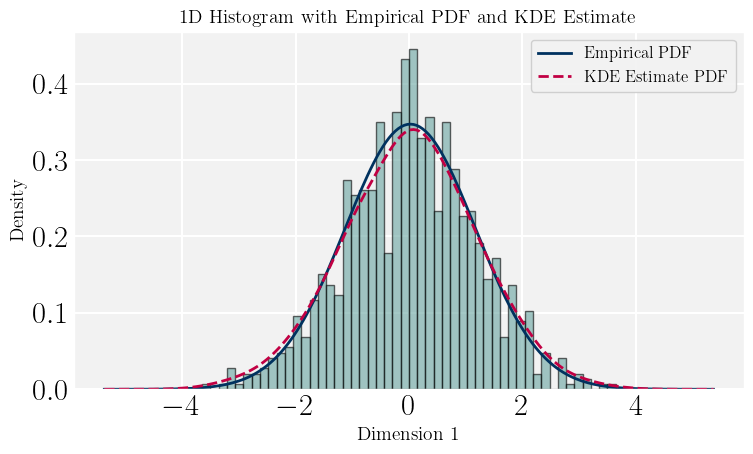

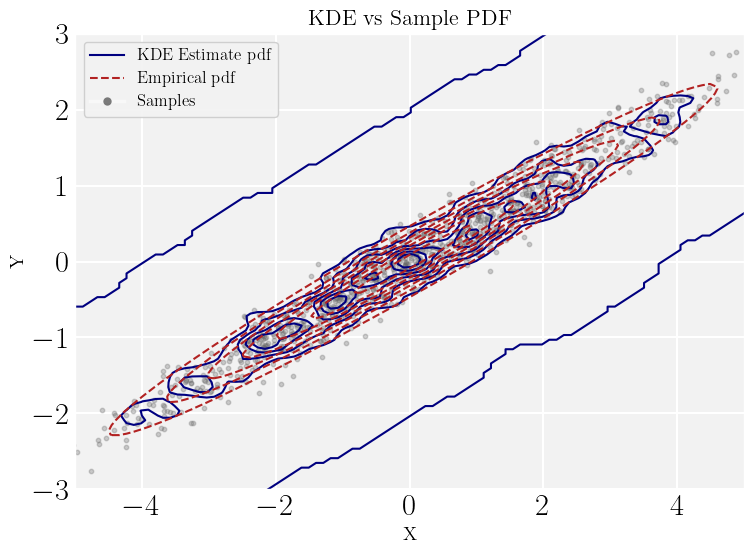


KL divergence (X marginal): 0.005868
KL divergence (Y marginal): 0.003005


KL divergence (2D): -0.290015



/var/folders/y5/q6z5mfgj6_g9z2bwg0jy91km0000gp/T/ipykernel_84971/680677185.py:200: RuntimeWarning: divide by zero encountered in log
  kl_terms = p * np.log(p / q)
/var/folders/y5/q6z5mfgj6_g9z2bwg0jy91km0000gp/T/ipykernel_84971/680677185.py:200: RuntimeWarning: invalid value encountered in multiply
  kl_terms = p * np.log(p / q)


In [ ]:
## calculating bandwidth matrix fully -> covariance included

# --- Generate 2D Gaussian samples
def generate_2d_gaussian_samples(n, mu, cov, seed=0):
    np.random.seed(seed)
    data = np.random.multivariate_normal(mu, cov, size=n).astype(np.float32)
    return data 

########################################################################
########################################################################

# --- calculate the bandwidth matrix
def scv_objective(params, data):
    """
    SCV objective function to minimize w.r.t. params that define bandwidth matrix H.

    Parameters:
        params: array-like of length d*(d+1)/2 (Cholesky lower triangular elements)
        data: (n_samples, d) data array

    Returns:
        scv_score: scalar, the SCV loss value
    """
    n, d = data.shape
    
    # Build lower-triangular matrix L from params
    lowerTriangularMatrix = np.zeros((d, d))
    tril_indices = np.tril_indices(d) # np.tril_indices: Return the indices for the lower-triangle of an (n, m) array.
    lowerTriangularMatrix[tril_indices] = params

    # Bandwidth matrix H = L L^T (symmetric positive definite)
    choleskyMatrix = lowerTriangularMatrix @ lowerTriangularMatrix.T

    # Inverse and determinant of the Cholesky Matrix
    H_inv = np.linalg.inv(choleskyMatrix)
    det_H = np.linalg.det(choleskyMatrix)

    norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_H))

    # Calculate the SCV score 
    score = 0.0
    for i in range(n):
        xi = data[i]
        otherDataLst = np.delete(data, i, axis=0) # removing the reference point 
        diffs = xi - otherDataLst  # shape: (n-1, d)
        dists = np.einsum('ij,jk,ik->i', diffs, H_inv, diffs)
        kernels = np.exp(-0.5 * dists)
        estimate = norm_const * np.mean(kernels)
        score -= np.log(estimate)  # use negative because scipy.optimize.minimize functions minimise them therefore by negating, we are maximising 

    # Average over all points
    scv_score = score / n

    return scv_score

def estimate_bandwidth_matrix_scv(data, initial_scale=1.0):
    """
    Estimate full bandwidth matrix H using Smoothed Cross-Validation (SCV).

    Parameters:
        data: (n_samples, d) input data
        initial_scale: float, initial bandwidth scale for starting L

    Returns:
        H_opt: (d, d) estimated bandwidth matrix
    """
    n, d = data.shape

    # Initialize L as scaled identity lower triangular
    initialCholeskyMatrix = np.zeros((d, d))
    np.fill_diagonal(initialCholeskyMatrix, initial_scale * np.std(data, axis=0))

    # Flatten lower triangle params for optimiser
    initial_params = initialCholeskyMatrix[np.tril_indices(d)]

    # Optimise SCV objective
    result = minimize(scv_objective, initial_params, args=(data,), method='L-BFGS-B')

    # Rebuild optimal H from result
    L_opt = np.zeros((d, d))
    L_opt[np.tril_indices(d)] = result.x # get the optimised parameters
    H_opt = L_opt @ L_opt.T

    return H_opt

########################################################################
########################################################################

# --- Cross-validation of KDE bandwidth matrix- using subsampling for speed
def calc_kdeCrossValidation_nD(data, H_Matrix_candidateLst, k=5, subsample_size=10000):
    n, d = data.shape
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # shuffle the data before splitting into k groups
    mean_logLikelihoodLst = []

    # Use subsampling to reduce computation
    if n > subsample_size:
        indices = np.random.choice(n, subsample_size, replace=False)
        data_sub = data[indices]
    else:
        data_sub = data

    for H in H_Matrix_candidateLst:
        H = np.array(H)
        H_inv = np.linalg.inv(H)
        det_H = np.linalg.det(H)

        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_H))

        fold_log_likelihoods = []

        for train_idx, val_idx in kf.split(data_sub):
            X_train = data_sub[train_idx]
            X_val = data_sub[val_idx]

            diffs = X_val[:, np.newaxis, :] - X_train[np.newaxis, :, :]
            dists = np.einsum('mnd,dd,mnd->mn', diffs, H_inv, diffs)
            K = norm_const * np.exp(-0.5 * dists)

            f_vals = np.mean(K, axis=1)
            f_vals = np.clip(f_vals, 1e-300, None)
            fold_log_likelihoods.append(np.mean(np.log(f_vals)))

        mean_logLikelihoodLst.append(np.mean(fold_log_likelihoods))

    mean_logLikelihoodLst = np.array(mean_logLikelihoodLst)
    optimal_idx = np.argmax(mean_logLikelihoodLst)
    optimalBandwidthMatrix = H_Matrix_candidateLst[optimal_idx]

    return optimalBandwidthMatrix, mean_logLikelihoodLst

# --- calcualte the PDF estimate and KDE estimate
def calc_pdf_and_kde_values(data, bandwidthMatrix, dim):

    # Get scalar bandwidth h = sqrt of diagonal element from bandwidthMatrix
    data_1d = data[:, dim]
    h = np.sqrt(bandwidthMatrix[dim, dim])

    # Compute mean and std for that dimension
    mean_x = np.mean(data_1d)
    std_x = np.std(data_1d, ddof=0)

    print(f"Using bandwidth h extracted from bandwidthMatrix diagonal: h = {h:.5f}")
    print(f"Mean = {round(mean_x, 5)}, Std = {round(std_x, 5)}")

    # Generate x values for plotting KDE and PDF
    x_vals = np.linspace(np.min(data_1d), np.max(data_1d), 500)

    # Empirical PDF assuming Gaussian distribution
    pdf_vals = norm.pdf(x_vals, loc=mean_x, scale=std_x)

    # calculate KDE values
    kde_vals = np.zeros_like(x_vals)
    for i, x in enumerate(x_vals):
        diff = (x - data_1d) / h
        kde_vals[i] = np.mean(np.exp(-0.5 * diff**2)) / (np.sqrt(2 * np.pi) * h)

    return x_vals, pdf_vals, kde_vals

# --- Calculate KL divergence in 1D - between two choosen flavours
def calc_KLDivergence(data, kde_vals_x, kde_vals_y, pdf_vals_x, pdf_vals_y):
    
    # Uniform grids from data, matching KDE/PDF lengths
    x_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), len(kde_vals_x))
    y_vals = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), len(kde_vals_y))

    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]

    # Clip to avoid log(0)
    eps = 1e-12
    P_x = np.clip(kde_vals_x, eps, None)
    Q_x = np.clip(pdf_vals_x, eps, None)

    P_y = np.clip(kde_vals_y, eps, None)
    Q_y = np.clip(pdf_vals_y, eps, None)

    # KL divergence via numerical integration - Riemann sum
    kl_x = np.sum(P_x * np.log(P_x / Q_x)) * dx
    kl_y = np.sum(P_y * np.log(P_y / Q_y)) * dy

    print(f"\nKL divergence (X marginal): {kl_x:.6f}")
    print(f"KL divergence (Y marginal): {kl_y:.6f}\n")


# --- Calculate the 1D pdf vals and kde vals from 1D distributions 
def calc_pdf_and_kde_values(data, bandwidthMatrix, dim, grid_points=200):
    # Extract data for selected dimension
    data_1d = data[:, dim]

    # Define evaluation points for KDE and PDF: evenly spaced over data range ± margin
    margin = 1.5 * np.std(data_1d)
    x_min = np.min(data_1d) - margin
    x_max = np.max(data_1d) + margin
    x_vals = np.linspace(x_min, x_max, grid_points)

    # Calculate Gaussian PDF parameters (mean and variance) from data in this dimension
    mu = np.mean(data_1d)
    var = np.var(data_1d)

    # Calculate theoretical PDF values at x_vals
    pdf_vals = norm.pdf(x_vals, loc=mu, scale=np.sqrt(var))

    # Calculate KDE values at x_vals

    # Bandwidth for the 1D KDE is the marginal variance from the bandwidth matrix in this dimension
    # Note: bandwidthMatrix is 2D covariance for KDE smoothing, so bandwidth = sqrt of diagonal element
    bandwidth_1d = np.sqrt(bandwidthMatrix[dim, dim])

    # Gaussian KDE formula:
    # KDE(x) = (1/n) * sum_{i=1}^n K_h(x - x_i)
    # where K_h is Gaussian kernel with bandwidth h (std deviation)
    n = len(data_1d)
    kde_vals = np.zeros_like(x_vals)

    for i, x in enumerate(x_vals):
        # Compute Gaussian kernel for all data points
        kernel_vals = (1 / (bandwidth_1d * np.sqrt(2 * np.pi))) * \
                      np.exp(-0.5 * ((x - data_1d) / bandwidth_1d) ** 2)
        kde_vals[i] = np.sum(kernel_vals) / n

    return x_vals, pdf_vals, kde_vals


# --- Estimate KDE at given points using batching 
def calc_kdeGaussianEstimate_nD(points, data, bandwidth, batch_size=50):
    n, d = data.shape
    m = points.shape[0]

    bandwidth_inv = np.linalg.inv(bandwidth)
    det_bandwidth = np.linalg.det(bandwidth)
    norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_bandwidth))

    densities = np.empty(m, dtype=np.float32)

    for start in range(0, m, batch_size): # calculate in batches to reduce computational load
        end = min(start + batch_size, m)
        batch = points[start:end].astype(np.float32) # slices to get a subset of points (exclusive slicing)
        diffs = batch[:, np.newaxis, :] - data  # (b, n, d)
        D2 = np.einsum('bnd,dd,bnd->bn', diffs, bandwidth_inv, diffs) # einsum - sinstein summation, general syntax is np.einsum(subscripts, *operands), these are the input subscripts bnd,dd,bnd and the output subscript is bn and summuation is over d because it doesnt appear in the outputs
        kernel_vals = norm_const * np.exp(-0.5 * D2)
        densities[start:end] = np.mean(kernel_vals, axis=1)

    return densities


def calc_KLDivergence_2D(grid_points, kde_vals_2d, pdf_vals_2d):
    """
    Compute KL divergence D_KL(P || Q) over a 2D grid:
    P = KDE estimate
    Q = reference PDF (true Gaussian)
    """

    # --- Flatten 2D grid values to 1D arrays
    p = kde_vals_2d.flatten()
    q = pdf_vals_2d.flatten()

    # --- Grid spacing
    x_unique = np.unique(grid_points[:, 0])
    y_unique = np.unique(grid_points[:, 1])
    dx = x_unique[1] - x_unique[0]
    dy = y_unique[1] - y_unique[0]
    dA = dx * dy

    # --- Clip to avoid log(0) and division by zero
    p = np.clip(p, 1e-300, None)
    q = np.clip(q, 1e-300, None)

    # --- Normalise both distributions over the grid
    p /= np.sum(p) * dA
    q /= np.sum(q) * dA

    # --- Compute KL divergence
    kl_terms = p * np.log(p / q)
    kl_terms = np.nan_to_num(kl_terms, nan=0.0, posinf=0.0, neginf=0.0)

    kl_2d = np.sum(kl_terms) * dA
    print(f"\nKL divergence (2D): {kl_2d:.6f}\n")
    return kl_2d


########################################################################
########################################################################

# --- Plot histogram
def plot_1D_histogram(data, x_vals, pdf_vals, kde_vals, dim, bins=50):

    data_1d = data[:, dim]

    # Plot histogram, empirical PDF, and KDE estimate
    plt.figure(figsize=(8, 5))
    plt.hist(data_1d, bins=bins, density=True, color='#68A5A1', edgecolor='black', alpha=0.6)
    plt.plot(x_vals, pdf_vals, lw=2, label="Empirical PDF")
    plt.plot(x_vals, kde_vals, '--', lw=2, label="KDE Estimate PDF")
    plt.xlabel(f"Dimension {dim}", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.title("1D Histogram with Empirical PDF and KDE Estimate", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# --- Plot histogram with scatter graph as well
def plot_1D_histogram_withScatter(data, x_vals, pdf_vals, kde_vals, dim, bins=50):
    data_1d = data[:, dim]

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=(4, 2), wspace=0.05)

    print(data_1d)

    # Left: Scatter plot
    ax_main = fig.add_subplot(gs[0])
    ax_main.scatter(np.arange(len(data_1d)), data_1d, color='#68A5A1', s=3)
    ax_main.set_ylabel(f"Dimension {dim}", fontsize=20)
    ax_main.set_xlabel(f"Replica Index", fontsize=20)
    ax_main.set_title("1D Histogram with Empirical PDF and KDE Estimate", fontsize=14)
    ax_main.set_title("1D Scatter Plot and Histogram with Empirical PDF and KDE Estimate", fontsize=16)
    ax_main.tick_params(axis='both', labelsize=12)
    ax_main.grid(True)

    # Right: Rotated histogram (density on x, value on y)
    ax_hist = fig.add_subplot(gs[1], sharey=ax_main)
    hist, bin_edges = np.histogram(data_1d, bins=bins, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bar_width = bin_edges[1] - bin_edges[0]
    ax_hist.barh(
        bin_centers,
        hist,
        height=bar_width,
        color="#68A5A1",
        edgecolor='black',
    )

    # Overlay: empirical PDF (solid line) and KDE estimate (dashed line)
    ax_hist.plot(pdf_vals, x_vals, lw=2, label='Empirical PDF')
    ax_hist.plot(kde_vals, x_vals, lw=2, linestyle='--', label='KDE Estimate')

    ax_hist.set_xlabel('Probability Density', fontsize=12, labelpad=12)
    ax_hist.tick_params(axis='x', labelsize=12)
    ax_hist.tick_params(axis='y', left=False, labelleft=False)
    ax_hist.set_xlim(left=0)
    ax_hist.legend(fontsize=10, loc='lower right')

    plt.tight_layout()
    plt.show()

########################################################################
########################################################################

# --- Plot KDE estimate and PDF estimate in 2D
def plot_kde_vs_pdf_2d(data, kde_vals, pdf_vals, grid_points):
    x_unique = np.unique(grid_points[:, 0])
    y_unique = np.unique(grid_points[:, 1])
    X, Y = np.meshgrid(x_unique, y_unique)

    # Downsample data for plotting if really large
    plot_data = data if data.shape[0] <= 10000 else data[::10]

    plt.scatter(plot_data[:, 0], plot_data[:, 1], c='dimgrey', s=10, alpha=0.3, label='Samples')
    plt.contour(X, Y, kde_vals, colors='navy', linewidths=1.5)
    plt.contour(X, Y, pdf_vals, colors='firebrick', linestyles='dashed', linewidths=1.5)

    legend_elements = [
        Line2D([0], [0], color='navy', lw=1.5, label='KDE Estimate pdf'),
        Line2D([0], [0], color='firebrick', lw=1.5, linestyle='dashed', label='Empirical pdf'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Samples', alpha=0.5)
    ]

    plt.xlim(-5,5)
    plt.ylim(-3,3)

    plt.legend(handles=legend_elements, fontsize=12)
    plt.title(f'KDE vs Sample PDF', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


########################################################################
########################################################################

# --- Define Distributions and run everything
def main(plotting1D=True, plotting2D=True, kdeGridRes=150):

    cov = [
        [6,3],
        [0.5,0.3]
    ]

    mu = [0,0]
    data = generate_2d_gaussian_samples(n=1000, mu=mu, cov=cov)
    bandwidthMatrix = estimate_bandwidth_matrix_scv(data)
    print(f"Estimated bandwidth matrix H: {bandwidthMatrix}\n")

    d = data.shape[1]
    if plotting1D == True:
        for dim in range(0, d):
            x_vals, pdf_vals, kde_vals = calc_pdf_and_kde_values(data, bandwidthMatrix, dim)
            plot_1D_histogram(data, x_vals, pdf_vals, kde_vals, dim)
            # plot_1D_histogram_withScatter(data, x_vals, pdf_vals, kde_vals, dim)

    if plotting2D == True:
        # Create 2D grid only for selected dims
        grid_axes_2d = [np.linspace(np.min(data[:, dim]) - 1, np.max(data[:, dim]) + 1, kdeGridRes) for dim in range(2)]

        # Create 2D meshgrid and flatten
        X, Y = np.meshgrid(grid_axes_2d[0], grid_axes_2d[1], indexing='xy')
        grid_points_2d = np.vstack([X.ravel(), Y.ravel()]).T.astype(np.float32)  # shape (num_points, 2)
                
        # Compute KDE only on selected dims
        kde_vals_2d = calc_kdeGaussianEstimate_nD(grid_points_2d, data, bandwidthMatrix).reshape(kdeGridRes, kdeGridRes)

        # Calculate sample PDF for selected dims
        sampleMean_2d = np.mean(data, axis=0)
        sampleCovariance_2d = np.cov(data, rowvar=False)
        sampleGaussian_2d = multivariate_normal(mean=sampleMean_2d, cov=sampleCovariance_2d)
        pdf_vals_2d = sampleGaussian_2d.pdf(grid_points_2d).reshape(kdeGridRes, kdeGridRes)

        # Plot with the 2D inputs    
        plot_kde_vs_pdf_2d(data, kde_vals_2d, pdf_vals_2d, grid_points_2d)

        # calculate the KL divergence 
        _, pdf_vals_x, kde_vals_x = calc_pdf_and_kde_values(data, bandwidthMatrix, dim, grid_points=200)
        _, pdf_vals_y, kde_vals_y = calc_pdf_and_kde_values(data, bandwidthMatrix, dim, grid_points=200)

        calc_KLDivergence(data, kde_vals_x, kde_vals_y, pdf_vals_x, pdf_vals_y)
        calc_KLDivergence_2D(grid_points_2d, kde_vals_2d, pdf_vals_2d)

        return data, bandwidthMatrix

data, bandwidthMatrix  = main()




In [6]:
###############################################
# --- KDE PDF Evaluation Function ---
###############################################

def calc_pdf_pointwise(point, data, bandwidthMatrix):
    d = data.shape[1] if data.ndim > 1 else 1
    n = data.shape[0]

    if d == 1:
        diffs = data - point
        D2 = (diffs / bandwidthMatrix) ** 2
        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * bandwidthMatrix)
        kernel_vals = np.exp(-0.5 * D2)
        return (1.0 / n) * np.sum(norm_const * kernel_vals)

    else:
        H_inv = np.linalg.inv(bandwidthMatrix)
        det_H = np.linalg.det(bandwidthMatrix)
        diffs = data - point
        u = diffs @ H_inv.T
        D2 = np.sum(u ** 2, axis=1)
        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * (det_H))
        kernel_vals = np.exp(-0.5 * D2)
        return (1.0 / n) * np.sum(norm_const * kernel_vals)


def calc_pdf_batch(points, data, bandwidthMatrix):
    """
    Vectorised KDE PDF evaluation at multiple points.

    points: (m, d) array of evaluation points
    data: (n, d) input data points
    bandwidth: (d, d) bandwidth matrix

    Returns:
        pdf_vals: (m,) KDE density values at each point
    """
    d = data.shape[1] if data.ndim > 1 else 1
    n = data.shape[0]
    m = points.shape[0]

    H_inv = np.linalg.inv(bandwidthMatrix)
    det_H = np.linalg.det(bandwidthMatrix)

    # Compute differences between each sample point and each data point:
    # Result shape (m, n, d): broadcast points and data
    diffs = points[:, np.newaxis, :] - data[np.newaxis, :, :]  # shape (m, n, d)

    # Apply bandwidth inverse: (m, n, d) @ (d, d)T -> (m, n, d)
    u = np.einsum('mnd,dk->mnk', diffs, H_inv.T)  # shape (m, n, d)

    # Squared Mahalanobis distances: sum over d
    D2 = np.sum(u**2, axis=2)  # shape (m, n)

    # Kernel values
    kernel_vals = np.exp(-0.5 * D2)  # shape (m, n)

    norm_const = 1.0 / (np.sqrt((2 * np.pi)**d) * det_H)

    # Sum over data points axis (n), average, and multiply by norm_const
    result = (norm_const / n) * np.sum(kernel_vals, axis=1)  # shape (m,)

    return result

###############################################
# --- General n-dimensional moment integration via KDE grid ---
###############################################

def calc_moment_integral_GridEvaluation(data, bandwidth, order, grid, differentialElement):
    d = data.shape[1]
    mesh = np.meshgrid(*grid, indexing='ij')
    shape = mesh[0].shape
    f_hats = np.empty(shape)

    grid_points = np.stack([g.ravel() for g in mesh], axis=1)

    for i, pt in enumerate(grid_points):
        f_hats.ravel()[i] = calc_pdf_pointwise(pt, data, bandwidth)
    
    if order == 0:
        # Zeroth moment: scalar total integral of KDE
        return np.sum(f_hats) * differentialElement
    else:
        # Moments: vector, one value per dimension
        moment_vec = np.zeros(d)
        for dim in range(d):
            coords_dim = mesh[dim]
            moment_vec[dim] = np.sum((coords_dim ** order) * f_hats) * differentialElement
        return moment_vec

###############################################
# --- calculate grid moments with bootstrap error ---
###############################################

def calc_moment_gridEvaulation(data, bandwidthMatrix, order, grid, differentialElement, n_bootstrap):
    n, d = data.shape
    stats = np.empty((n_bootstrap, d))

    for i in range(n_bootstrap):
        idxs = np.random.choice(n, size=n, replace=True)
        sample = data[idxs]
        stats[i] = calc_moment_integral_GridEvaluation(sample, bandwidthMatrix, order, grid, differentialElement)

    # mean_stat = np.mean(stats, axis=0)
    std_stat = np.std(stats, axis=0, ddof=1)
    
    return std_stat

###############################################
# --- Empirical moment stat functions ---
###############################################

def mean_stat(data_sample):
    return np.mean(data_sample, axis=0)

def variance_stat(data_sample):
    return np.var(data_sample, axis=0, ddof=1)

def third_moment_stat(data_sample):
    return np.mean(data_sample ** 3, axis=0)

def fourth_moment_stat(data_sample):
    return np.mean(data_sample ** 4, axis=0)

###############################################
# --- Bootstrap error for empirical moments ---
###############################################

def bootstrap_error(data, stat_func, n_bootstrap):
    n = data.shape[0]
    indices = np.random.choice(n, size=(n_bootstrap, n), replace=True)
    samples = data[indices]

    stats = np.array([stat_func(sample) for sample in samples])
    return np.mean(stats, axis=0), np.std(stats, axis=0, ddof=1)

###############################################
# --- Calculate central moments and kurtosis ---
###############################################

def calc_central_moments_from_raw(mean, second_moment, third_moment, fourth_moment):
    
    variance = second_moment - mean ** 2
    fourth_central = fourth_moment - 4 * mean * third_moment + 6 * (mean ** 2) * second_moment - 3 * (mean ** 4)
    kurtosis = fourth_central / (variance ** 2) - 3

    return variance, kurtosis

def calc_central_moments_data(data):
    mean = np.mean(data, axis=0)
    diff = data - mean
    variance = np.mean(diff ** 2, axis=0)
    fourth_central = np.mean(diff ** 4, axis=0)
    kurtosis = fourth_central / (variance ** 2) - 3
    return mean, variance, kurtosis

###############################################
# --- Grid setup helper ---
###############################################

def setup_nd_grid(data, k=3, grid_res=50):
    n, d = data.shape
    mean_vec = np.mean(data, axis=0)
    std_vec = np.std(data, axis=0, ddof=1)
    lower = mean_vec - k * std_vec
    upper = mean_vec + k * std_vec

    grid = []
    dx_list = []

    for i in range(d):
        axis_points = np.linspace(lower[i], upper[i], grid_res)
        dx = axis_points[1] - axis_points[0]
        grid.append(axis_points)
        dx_list.append(dx)

    dV = np.prod(dx_list)  # volume element - assuming multidimensional square
    
    return grid, dV

###############################################
# --- Full analysis comparing grid KDE and empirical moments ---
###############################################

def run_full_moment_analysis(data, bandwidthMatrix, grid, dV, n_bootstrap=50):
    
    # Compute moments by KDE grid integration + bootstrap error
    zeroth_grid = calc_moment_integral_GridEvaluation(data, bandwidthMatrix, order=0, grid=grid, differentialElement=dV)
    mean_grid = calc_moment_integral_GridEvaluation(data, bandwidthMatrix, order=1, grid=grid, differentialElement=dV)
    second_moment_grid = calc_moment_integral_GridEvaluation(data, bandwidthMatrix, order=2, grid=grid, differentialElement=dV)
    third_moment_grid = calc_moment_integral_GridEvaluation(data, bandwidthMatrix, order=3, grid=grid, differentialElement=dV)
    fourth_moment_grid = calc_moment_integral_GridEvaluation(data, bandwidthMatrix, order=4, grid=grid, differentialElement=dV)
    
    _, error_zeorth_grid = calc_moment_gridEvaulation(data, bandwidthMatrix, 0, grid, dV, n_bootstrap)
    _, error_mean_grid = calc_moment_gridEvaulation(data, bandwidthMatrix, 1, grid, dV, n_bootstrap)
    _, error_second_moment_grid = calc_moment_gridEvaulation(data, bandwidthMatrix, 2, grid, dV, n_bootstrap)
    _, error_third_moment_grid = calc_moment_gridEvaulation(data, bandwidthMatrix, 3, grid, dV, n_bootstrap)
    _, error_fourth_moment_grid = calc_moment_gridEvaulation(data, bandwidthMatrix, 4, grid, dV, n_bootstrap)

    variance_grid, kurtosis_grid = calc_central_moments_from_raw(mean_grid, second_moment_grid, third_moment_grid, fourth_moment_grid)

    # Empirical moments + bootstrap errors
    empirical_mean = np.mean(data, axis=0)
    empirical_variance = np.var(data, axis=0, ddof=1)
    empirical_second_moment = np.mean(data ** 2, axis=0)
    empirical_third_moment = np.mean(data ** 3, axis=0)
    empirical_fourth_moment = np.mean(data ** 4, axis=0)
    empirical_variance_central, empirical_kurtosis = calc_central_moments_from_raw(empirical_mean, empirical_second_moment, empirical_third_moment, empirical_fourth_moment)

    _, bootstrapError_mean = bootstrap_error(data, mean_stat, n_bootstrap)
    _, bootstrapError_variance = bootstrap_error(data, variance_stat, n_bootstrap)
    _, bootstrapError_fourth = bootstrap_error(data, fourth_moment_stat, n_bootstrap)
    bootstrapError_kurtosis = 'implement'

    print("\n--- Moments ---")
    print(f"Zeroth (KDE): {zeroth_grid} with error {error_zeorth_grid}\n")
    
    print(f"Mean (KDE): {mean_grid} with error {error_mean_grid}")
    print(f"Mean (Empirical): {empirical_mean} with error {bootstrapError_mean}\n")

    print(f"Variance (KDE): {variance_grid} with error {error_second_moment_grid}")
    print(f"Variance (Empirical): {empirical_variance} with error {bootstrapError_variance}\n")

    print(f"Kurtosis (KDE): {kurtosis_grid} with error {error_fourth_moment_grid}")
    print(f"Kurtosis (Empirical): {empirical_kurtosis} with error {bootstrapError_kurtosis}\n")

###############################################
# --- Call Functions ---
###############################################

# Setup grid and differential volume element:
grid, dV = setup_nd_grid(data, k=3, grid_res=100)

# Run full moment analysis:
run_full_moment_analysis(data, bandwidthMatrix, grid, dV, n_bootstrap=50)


KeyboardInterrupt: 

In [ ]:
###############################################
# --- KDE PDF Evaluation Function ---
###############################################

def calc_pdf_pointwise(point, data, bandwidthMatrix):
    d = data.shape[1] if data.ndim > 1 else 1
    n = data.shape[0]

    if d == 1:
        diffs = data - point
        D2 = (diffs / bandwidthMatrix) ** 2
        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * bandwidthMatrix)
        kernel_vals = np.exp(-0.5 * D2)
        return (1.0 / n) * np.sum(norm_const * kernel_vals)

    else:
        H_inv = np.linalg.inv(bandwidthMatrix)
        det_H = np.linalg.det(bandwidthMatrix)
        diffs = data - point
        u = diffs @ H_inv.T
        D2 = np.sum(u ** 2, axis=1)
        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * (det_H))
        kernel_vals = np.exp(-0.5 * D2)
        return (1.0 / n) * np.sum(norm_const * kernel_vals)

def calc_pdf_batch(points, data, bandwidthMatrix):
    """
    Vectorised KDE PDF evaluation at multiple points.

    points: (m, d) array of evaluation points
    data: (n, d) input data points
    bandwidth: (d, d) bandwidth matrix

    Returns:
        pdf_vals: (m,) KDE density values at each point
    """
    d = data.shape[1] if data.ndim > 1 else 1
    n = data.shape[0]
    m = points.shape[0]

    H_inv = np.linalg.inv(bandwidthMatrix)
    det_H = np.linalg.det(bandwidthMatrix)

    # Compute differences between each sample point and each data point:
    # Result shape (m, n, d): broadcast points and data
    diffs = points[:, np.newaxis, :] - data[np.newaxis, :, :]  # shape (m, n, d)

    # Apply bandwidth inverse: (m, n, d) @ (d, d)T -> (m, n, d)
    u = np.einsum('mnd,dk->mnk', diffs, H_inv.T)  # shape (m, n, d)

    # Squared Mahalanobis distances: sum over d
    D2 = np.sum(u**2, axis=2)  # shape (m, n)

    # Kernel values
    kernel_vals = np.exp(-0.5 * D2)  # shape (m, n)

    norm_const = 1.0 / (np.sqrt((2 * np.pi)**d) * det_H)

    # Sum over data points axis (n), average, and multiply by norm_const
    result = (norm_const / n) * np.sum(kernel_vals, axis=1)  # shape (m,)

    return result

###############################################
# --- Monte Carlo moment integration ---
###############################################

def monte_carlo_moment_integration(data, bandwidth, order, n_samples_mc=10000, seed=42, k=3):
    np.random.seed(seed)
    n, d = data.shape

    # Define sampling bounds using data mean ± k * std 
    mean_vec = np.mean(data, axis=0)
    std_vec = np.std(data, axis=0, ddof=1)
    lower = mean_vec - k * std_vec
    upper = mean_vec + k * std_vec

    # Sample uniformly inside the hyper-rectangle (MC sampling)
    samples_mc = np.random.uniform(low=lower, high=upper, size=(n_samples_mc, d))

    # Evaluate KDE at these points
    # f_hats = np.array([calc_pdf_pointwise(pt, data, bandwidth) for pt in samples_mc])
    f_hats = calc_pdf_batch(samples_mc, data, bandwidthMatrix)

    # Calculate moment: E[x^order] ~ 1/V * sum((x^order) * f_hat) * V = mean of (x^order * f_hat)
    # where V = volume of sampling domain
    volume = np.prod(upper - lower)

    # Compute moment vector
    moment_vec = np.zeros(d)
    for dim in range(d):
        moment_vec[dim] = volume * np.mean((samples_mc[:, dim] ** order) * f_hats)

    return moment_vec

###############################################
# --- Bootstrap error for MC moments ---
###############################################

def bootstrap_mc_error(data, bandwidthMatrix, order, n_bootstrap=50, n_samples_mc=10000):
    n, d = data.shape
    moments = np.empty((n_bootstrap, d))

    for i in range(n_bootstrap):
        idxs = np.random.choice(n, size=n, replace=True)
        sample = data[idxs]
        moments[i] = monte_carlo_moment_integration(sample, bandwidthMatrix, order, n_samples_mc=n_samples_mc)

    mean_moment = np.mean(moments, axis=0)
    std_moment = np.std(moments, axis=0, ddof=1)

    return mean_moment, std_moment

###############################################
# --- Empirical moment stat functions ---
###############################################

def mean_stat(data_sample):
    return np.mean(data_sample, axis=0)

def variance_stat(data_sample):
    return np.var(data_sample, axis=0, ddof=1)

def fourth_moment_stat(data_sample):
    return np.mean(data_sample ** 4, axis=0)

###############################################
# --- Bootstrap error for empirical moments ---
###############################################

def bootstrap_error(data, stat_func, n_bootstrap):
    n = data.shape[0]
    indices = np.random.choice(n, size=(n_bootstrap, n), replace=True)
    samples = data[indices]
    stats = np.array([stat_func(sample) for sample in samples])
    
    return np.mean(stats, axis=0), np.std(stats, axis=0, ddof=1)

###############################################
# --- Calculate central moments and kurtosis ---
###############################################

def calc_central_moments_from_raw(mean, second_moment, third_moment, fourth_moment):

    variance = second_moment - mean**2
    fourth_central = fourth_moment \
                     - (4 * mean * third_moment) \
                     + (6 * (mean ** 2) * second_moment) \
                     - (3 * (mean ** 4))

    kurtosis = fourth_central / (variance ** 2) - 3 # normalised fourth central moment

    return variance, kurtosis


###############################################
# --- Full analysis comparing MC KDE and empirical moments ---
###############################################

def run_full_moment_analysis_mc(data, bandwidthMatrix, n_bootstrap=50, n_samples_mc=10000):
    
    # Compute moments by KDE MC integration
    zeroth_mc = monte_carlo_moment_integration(data, bandwidthMatrix, order=0, n_samples_mc=10000)
    mean_mc = monte_carlo_moment_integration(data, bandwidthMatrix, order=1, n_samples_mc=10000)
    second_moment_mc = monte_carlo_moment_integration(data, bandwidthMatrix, order=2, n_samples_mc=10000)
    third_moment_mc = monte_carlo_moment_integration(data, bandwidthMatrix, order=3, n_samples_mc=10000)
    fourth_moment_mc = monte_carlo_moment_integration(data, bandwidthMatrix, order=4, n_samples_mc=10000)

    # Compute moments bootstrap error
    _, error_zeorth_mc = bootstrap_mc_error(data, bandwidthMatrix, 0, n_bootstrap, n_samples_mc)
    _, error_mean_mc = bootstrap_mc_error(data, bandwidthMatrix, 1, n_bootstrap, n_samples_mc)
    _, error_second_moment_mc = bootstrap_mc_error(data, bandwidthMatrix, 2, n_bootstrap, n_samples_mc)
    _, error_fourth_moment_mc = bootstrap_mc_error(data, bandwidthMatrix, 4, n_bootstrap, n_samples_mc)

    variance_mc, kurtosis_mc = calc_central_moments_from_raw(mean_mc, second_moment_mc, third_moment_mc, fourth_moment_mc)

    # Empirical moments + bootstrap errors
    empirical_mean = np.mean(data, axis=0)
    empirical_second_moment = np.var(data, axis=0, ddof=1)
    empirical_third_moment = np.mean(data ** 3, axis=0)
    empirical_fourth_moment = np.mean(data ** 4, axis=0)
    empirical_variance, empirical_kurtosis = calc_central_moments_from_raw(empirical_mean, empirical_second_moment, empirical_third_moment, empirical_fourth_moment)

    _, bootstrapError_mean = bootstrap_error(data, mean_stat, n_bootstrap)
    _, bootstrapError_variance = bootstrap_error(data, variance_stat, n_bootstrap)
    _, bootstrapError_fourth = bootstrap_error(data, fourth_moment_stat, n_bootstrap)
    bootstrapError_kurtosis = 'implement'

    print("\n--- Moments ---")
    print(f"Zeroth (KDE): {zeroth_mc} with error {error_zeorth_mc}\n")
    
    print(f"Mean (KDE): {mean_mc} with error {error_mean_mc}")
    print(f"Mean (Empirical): {empirical_mean} with error {bootstrapError_mean}\n")

    print(f"Variance (KDE): {variance_mc} with error {error_second_moment_mc}")
    print(f"Variance (Empirical): {empirical_variance} with error {bootstrapError_variance}\n")

    print(f"Kurtosis (KDE): {kurtosis_mc} with error {error_fourth_moment_mc}")
    print(f"Kurtosis (Empirical): {empirical_kurtosis} with error {bootstrapError_kurtosis}\n")

###############################################
# --- Run Code ---
###############################################

run_full_moment_analysis_mc(data, bandwidthMatrix, n_bootstrap=50, n_samples_mc=10000)


--- Moments ---
Zeroth (KDE): [0.97986959 0.97986959] with error [4.48597845e-16 4.48597845e-16]

Mean (KDE): [0.1215095  0.06146414] with error [2.80373653e-17 3.50467067e-18]
Mean (Empirical): [0.05137016 0.02338411] with error [0.0712788  0.03536521]

Variance (KDE): [5.31469644 1.36014256] with error [4.48597845e-15 0.00000000e+00]
Variance (Empirical): [5.1165724 1.3224506] with error [0.2088004  0.05563884]

Kurtosis (KDE): [-0.13826911 -0.07194556] with error [1.43551311e-14 8.97195691e-15]
Kurtosis (Empirical): [-0.0239284   0.04071593] with error implement



In [ ]:
###############################################
# --- KDE PDF Evaluation Function ---
###############################################

def calc_pdf_pointwise(point, data, bandwidthMatrix):
    d = data.shape[1] if data.ndim > 1 else 1
    n = data.shape[0]

    if d == 1:
        diffs = data - point
        D2 = (diffs / bandwidthMatrix) ** 2
        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * bandwidthMatrix)
        kernel_vals = np.exp(-0.5 * D2)
        return (1.0 / n) * np.sum(norm_const * kernel_vals)

    else:
        H_inv = np.linalg.inv(bandwidthMatrix)
        det_H = np.linalg.det(bandwidthMatrix)
        diffs = data - point
        u = diffs @ H_inv.T
        D2 = np.sum(u ** 2, axis=1)
        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * (det_H))
        kernel_vals = np.exp(-0.5 * D2)
        return (1.0 / n) * np.sum(norm_const * kernel_vals)

def calc_pdf_batch(points, data, bandwidthMatrix):
    """
    Vectorised KDE PDF evaluation at multiple points.

    points: (m, d) array of evaluation points
    data: (n, d) input data points
    bandwidth: (d, d) bandwidth matrix

    Returns:
        pdf_vals: (m,) KDE density values at each point
    """
    d = data.shape[1] if data.ndim > 1 else 1
    n = data.shape[0]
    m = points.shape[0]

    H_inv = np.linalg.inv(bandwidthMatrix)
    det_H = np.linalg.det(bandwidthMatrix)

    # Compute differences between each sample point and each data point:
    # Result shape (m, n, d): broadcast points and data
    diffs = points[:, np.newaxis, :] - data[np.newaxis, :, :]  # shape (m, n, d)

    # Apply bandwidth inverse: (m, n, d) @ (d, d)T -> (m, n, d)
    u = np.einsum('mnd,dk->mnk', diffs, H_inv.T)  # shape (m, n, d)

    # Squared Mahalanobis distances: sum over d
    D2 = np.sum(u**2, axis=2)  # shape (m, n)

    # Kernel values
    kernel_vals = np.exp(-0.5 * D2)  # shape (m, n)

    norm_const = 1.0 / (np.sqrt((2 * np.pi)**d) * det_H)

    # Sum over data points axis (n), average, and multiply by norm_const
    result = (norm_const / n) * np.sum(kernel_vals, axis=1)  # shape (m,)

    return result

###############################################
# --- Monte Carlo moment integration ---
###############################################

def calc_moments_importanceSampling(data, bandwidthMatrix, n_samplesMC):
    """
    Calculate the moment vector via Monte Carlo importance sampling of KDE.
    Supports n dimensions.

    integral of the form I = integral f_x * p_x dx can be approximated as 1/N * sum (p_x / q_x) * f_x
    where 
        p_x = actual distribution (usually hard to sample from)
        q_x = approximate / guess distribution (in theory a version of p_x that you can sample from)
        f_x = function of interest - in our case for zeorth moment = 1, first moment = x, second moment = x^2 etc
    """

    # Proposal distribution q(x) ~ N(mu, cov) - calculated from data, the sample mean and co-variance
    mu = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)

    samples = np.random.multivariate_normal(mu, cov, size=n_samplesMC)
    q_dist = multivariate_normal(mean=mu, cov=cov) # create multivariate normal object for q(x)
    q_vals = q_dist.pdf(samples)

    # p_vals = [calc_pdf_pointwise(point, data, bandwidthMatrix) for point in samples]
    p_vals = calc_pdf_batch(samples, data, bandwidthMatrix)
    weightsLst = p_vals / q_vals # shape (n_samples,)

    # zeroth Moment - normalisation check
    zerothMoment = np.mean(weightsLst) # f(x) = 1 thus I ~ 1/N sum of p(x) / q(x) - the mean of the weightsLst

    # Mean - first moment
    f_x_first = samples  # shape (n_samples, d)
    weighted_f_x = weightsLst[:, None] * f_x_first  # shape (n_samples, d) - broadcast along dimensions - basically duplicate the weightsLst element wise to mutliply by f_x_first
    weighted_sum = np.sum(weighted_f_x, axis=0)
    weight_sum = np.sum(weightsLst)
    firstMomentVec = weighted_sum / weight_sum # divide for normalisation 

    # Second Moment
    f_x_second = samples**2  # shape (n_samples, d)
    weighted_f_x = weightsLst[:, None] * f_x_second  # shape (n_samples, d)
    weighted_sum = np.sum(weighted_f_x, axis=0)
    weight_sum = np.sum(weightsLst)
    secondMomentVec = weighted_sum / weight_sum

    # Third Moment
    f_x_third = samples**3
    weighted_f_x = weightsLst[:, None] * f_x_third
    weighted_sum = np.sum(weighted_f_x, axis=0)
    weight_sum = np.sum(weightsLst)
    thirdMomentVec = weighted_sum / weight_sum

    # Fourth Moment
    f_x_fourth = samples**4
    weighted_f_x = weightsLst[:, None] * f_x_fourth
    weighted_sum = np.sum(weighted_f_x, axis=0)
    weight_sum = np.sum(weightsLst)
    fourthMomentVec = weighted_sum / weight_sum

    varianceVec = secondMomentVec - firstMomentVec**2
    fourthCumulant = (fourthMomentVec \
        - 4 * thirdMomentVec * firstMomentVec \
        - 3 * secondMomentVec**2 \
        + 12 * secondMomentVec * firstMomentVec**2 \
        - 6 * firstMomentVec**4) 
    
    kurtosis = fourthCumulant / (np.std(data, axis=0)**4)
    
    return zerothMoment, firstMomentVec, varianceVec, kurtosis

###############################################
# --- Bootstrap error for MC moments ---
###############################################

def bootstrap_error_mc_importance(data, bandwidthMatrix, n_bootstrap, n_samplesBootStrap):
    """
    Bootstrap standard error for importance sampling KDE moments.
    Uses calc_moments_importanceSampling.
    """
    n, d = data.shape

    zeroth_moments = np.zeros(n_bootstrap)
    first_moments = np.zeros((n_bootstrap, d))
    variances = np.zeros((n_bootstrap, d))
    fourthCumulants = np.zeros((n_bootstrap, d))

    for i in range(n_bootstrap):
        idxs = np.random.choice(n, size=n, replace=True)
        resampled_data = data[idxs]

        zerothMoment, firstMomentVec, varianceVec, fourthCumulantVec = calc_moments_importanceSampling(
            resampled_data, bandwidthMatrix, n_samplesMC=n_samplesBootStrap)

        zeroth_moments[i] = zerothMoment
        first_moments[i] = firstMomentVec
        variances[i] = varianceVec
        fourthCumulants[i] = fourthCumulantVec

    std_zeroth = np.std(zeroth_moments, ddof=1)
    std_first = np.std(first_moments, axis=0, ddof=1)
    std_variance = np.std(variances, axis=0, ddof=1)
    std_fourthCumulant = np.std(fourthCumulants, axis=0, ddof=1)

    return std_zeroth, std_first, std_variance, std_fourthCumulant

###############################################
# --- Empirical moment stat functions ---
###############################################

def mean_stat(data_sample):
    return np.mean(data_sample, axis=0)

def variance_stat(data_sample):
    return np.var(data_sample, axis=0, ddof=1)

def fourth_moment_stat(data_sample):
    return np.mean(data_sample ** 4, axis=0)

###############################################
# --- Bootstrap error for empirical moments ---
###############################################

def bootstrap_error(data, stat_func, n_bootstrap):
    n = data.shape[0]
    indices = np.random.choice(n, size=(n_bootstrap, n), replace=True)
    samples = data[indices]
    stats = np.array([stat_func(sample) for sample in samples])
    
    return np.mean(stats, axis=0), np.std(stats, axis=0, ddof=1)

###############################################
# --- Calculate central moments and kurtosis ---
###############################################

def calc_central_moments_from_raw(mean, second_moment, third_moment, fourth_moment):
    
    variance = second_moment - mean ** 2
    fourth_central = fourth_moment - 4 * mean * third_moment + 6 * (mean ** 2) * second_moment - 3 * (mean ** 4)
    kurtosis = fourth_central / (variance ** 2) - 3

    return variance, kurtosis

###############################################
# --- Full analysis comparing MC KDE and empirical moments ---
###############################################

def run_full_moment_analysis_mc(data, bandwidthMatrix, n_bootstrap=100, n_samples_mc=10000):
    
    # Compute moments by KDE MC integration
    zeroth_is, mean_is, variance_is, kurtosis_is = calc_moments_importanceSampling(data, bandwidthMatrix, n_samples_mc)
    error_zeorth_is, bootstrapError_mean_is, bootstrapError_variance_is, bootstrapError_kurtosis_is = bootstrap_error_mc_importance(data, bandwidthMatrix, n_bootstrap, n_bootstrap)

    # Empirical moments + bootstrap errors
    empirical_mean = np.mean(data, axis=0)
    empirical_variance = np.var(data, axis=0, ddof=1)
    empirical_second_moment = np.mean(data ** 2, axis=0)
    empirical_third_moment = np.mean(data ** 3, axis=0)
    empirical_fourth_moment = np.mean(data ** 4, axis=0)
    empirical_variance_central, empirical_kurtosis = calc_central_moments_from_raw(empirical_mean, empirical_second_moment, empirical_third_moment, empirical_fourth_moment)

    _, bootstrapError_mean = bootstrap_error(data, mean_stat, n_bootstrap)
    _, bootstrapError_variance = bootstrap_error(data, variance_stat, n_bootstrap)
    # _, bootstrapError_fourth = bootstrap_error(data, fourth_moment_stat, n_bootstrap)
    bootstrapError_kurtosis = 'TODO'

    print("\n--- Moments ---")
    print(f"Zeroth (KDE): {zeroth_is} with error {error_zeorth_is}\n")
    
    print(f"Mean (KDE): {mean_is} with error {bootstrapError_mean_is}")
    print(f"Mean (Empirical): {empirical_mean} with error {bootstrapError_mean}\n")

    print(f"Variance (KDE): {variance_is} with error {bootstrapError_variance_is}")
    print(f"Variance (Empirical): {empirical_variance} with error {bootstrapError_variance}\n")

    print(f"Kurtosis (KDE): {kurtosis_is} with error {bootstrapError_kurtosis_is}")
    print(f"Kurtosis (Empirical): {empirical_kurtosis} with error {bootstrapError_kurtosis}\n")

###############################################
# --- Run Code ---
###############################################

run_full_moment_analysis_mc(data, bandwidthMatrix, n_bootstrap=50, n_samples_mc=10000)



--- Moments ---
Zeroth (KDE): 1.0109088346122432 with error 0.14690436421853925

Mean (KDE): [0.13064054 0.06428828] with error [0.63705237 0.315605  ]
Mean (Empirical): [0.05137016 0.02338411] with error [0.06558128 0.03377301]

Variance (KDE): [6.01535145 1.53402859] with error [1.75236745 0.41500403]
Variance (Empirical): [5.119211  1.3229975] with error [0.20941332 0.05480369]

Kurtosis (KDE): [0.01712276 0.07613513] with error [0.96728044 0.85641831]
Kurtosis (Empirical): [-0.02104139  0.0442915 ] with error TODO

